# Exploitation rate of krill based on krill distribution (krillpodym) and CCAMLR catch data

In [1]:
# import libraries (ok sous base anaconda)
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import math
import seaborn as sns
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

Cannot find header.dxf (GDAL_DATA is not defined)


In [20]:
os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/outputs_formated_data')

krill =  pd.read_csv('Krill_biomass_df_final.csv')[['latitude',	'longitude', 'krill_adults', 'krill_adult_log']]
catch = pd.read_csv('Krill_catch_final.csv')[['latitude',	'longitude', 'krill_greenweight_kg']]

# load ocim for the cells areas
OCIM = xr.open_dataset('fseq_OCIM2_48L_interpolated_SO.nc')
area_df = OCIM[['AREA', 'MASK']].isel(depth=0).to_dataframe().drop(['depth'], axis = 1).reset_index() # areas in m²
area_df = area_df[area_df['latitude'] <=-45]
area_df['True_area'] = area_df['AREA']*area_df['MASK']

,latitude,longitude,AREA,MASK,True_area
0,-79,-179.0,9.332850e+09,0.061111,5.703408e+08
1,-79,-177.0,9.332850e+09,0.061111,5.703408e+08
2,-79,-175.0,9.332850e+09,0.061111,5.703408e+08
3,-79,-173.0,9.332850e+09,0.061111,5.703408e+08
4,-79,-171.0,9.332850e+09,0.061111,5.703408e+08
...,...,...,...,...,...
3235,-45,171.0,3.458337e+10,0.750000,2.593752e+10
3236,-45,173.0,3.458337e+10,1.000000,3.458337e+10
3237,-45,175.0,3.458337e+10,1.000000,3.458337e+10
3238,-45,177.0,3.458337e+10,1.000000,3.458337e+10


In [40]:
catch

,latitude,longitude,krill_greenweight_kg
0,-69,-179,NaN
1,-69,-177,NaN
2,-69,-175,NaN
3,-69,-173,NaN
4,-69,-171,NaN
...,...,...,...
1795,-51,171,NaN
1796,-51,173,NaN
1797,-51,175,NaN
1798,-51,177,NaN


In [24]:
# merge the data together and with areas of the cells
data = pd.merge(catch, krill, how = 'left', on = ['latitude',	'longitude'])
data = pd.merge(data, area_df[['latitude',	'longitude','True_area']], how = 'left', on = ['latitude',	'longitude'])
data['krill_biomass'] = (data['krill_adults'] * data['True_area']) / 1000 # krill biomass in kg per cell
data['krill_exploit_rate'] = data['krill_greenweight_kg'] / data['krill_biomass']
data

,latitude,longitude,krill_greenweight_kg,krill_adults,krill_adult_log,True_area,krill_biomass,krill_exploit_rate
0,-69,-179,NaN,8.841167e+01,1.95139,1.752802e+10,1.549682e+09,NaN
1,-69,-177,NaN,1.859959e+01,1.29225,1.752802e+10,3.260141e+08,NaN
2,-69,-175,NaN,3.059019e+01,1.49955,1.752802e+10,5.361856e+08,NaN
3,-69,-173,NaN,6.540020e+01,1.82217,1.752802e+10,1.146336e+09,NaN
4,-69,-171,NaN,1.222669e+01,1.12145,1.752802e+10,2.143097e+08,NaN
...,...,...,...,...,...,...,...,...
1795,-51,171,NaN,-4.780213e-37,0.00000,3.077929e+10,-1.471316e-29,NaN
1796,-51,173,NaN,4.890532e-43,0.00000,3.077929e+10,1.505271e-35,NaN
1797,-51,175,NaN,4.439224e-38,0.00000,3.077929e+10,1.366362e-30,NaN
1798,-51,177,NaN,1.568696e-35,0.00000,3.077929e+10,4.828334e-28,NaN


<Axes: >

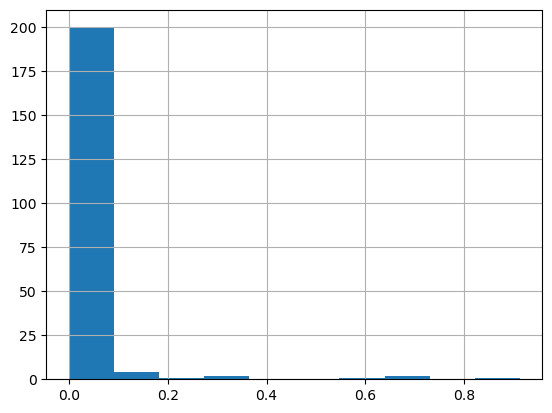

In [25]:
data['krill_exploit_rate'].hist()

In [29]:
data_xarray["krill_exploit_rate"]

<xarray.DataArray 'krill_exploit_rate' (index: 1800)>
array([nan, nan, nan, ..., nan, nan, nan])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 1793 1794 1795 1796 1797 1798 1799

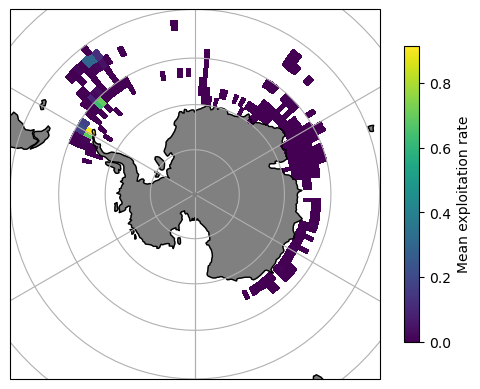

In [41]:
data_xarray = xr.Dataset.from_dataframe(data.set_index(['latitude',	'longitude']))

#os.chdir('C:/Users/anael/Documents/PhD/4_krill_fisheries_Carbon_seq_time/Git_repo/Key_Areas_krill_carbon_sequestration/figures')

map_proj = ccrs.SouthPolarStereo()

p = data_xarray["krill_exploit_rate"].plot(
    transform=ccrs.PlateCarree(),  # the data's projection
    add_colorbar = False,
    subplot_kws={"projection": map_proj},
    cmap = 'viridis'
) 

p.axes.gridlines()
p.axes.add_feature(cfeature.LAND, color='grey')
p.axes.add_feature(cfeature.COASTLINE)
cb = plt.colorbar(p, label = "Mean exploitation rate" , shrink = 0.8)
plt.title('') # using average of krill catch per year -- title : Average exploitation rate from 1988 to 2023

#plt.savefig('p_exploitation_rate.png')

In [38]:
data['krill_exploit_rate'].mean() # 0.021406148258414814
data['krill_exploit_rate'].max() # 0.9126481061110975
data['krill_exploit_rate'].min() # 0
data['krill_exploit_rate'].median() # 2.3269617405102626e-05

2.3269617405102626e-05